# Importing Libraries & Loading the Data

In [1]:
!pip install catboost

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
pd.options.display.float_format = '{:.5f}'.format

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from catboost import CatBoostClassifier
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans

In [3]:
# Load files
train = pd.read_csv('/content/drive/MyDrive/umojahack-africa-2022-beginner-challenge/train.csv', parse_dates = ['Datetime'])
test = pd.read_csv('/content/drive/MyDrive/umojahack-africa-2022-beginner-challenge/test.csv', parse_dates = ['Datetime'])
samplesubmission = pd.read_csv('/content/drive/MyDrive/umojahack-africa-2022-beginner-challenge/SampleSubmission.csv')

# Preview train dataset
train.head()

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault
0,ID_QF0ZTQJ2SF5Q,2021-11-03 04:06:31,52.58000,49.52000,17.40000,96.00000,0
1,ID_4GTK689CNX5S,2021-11-08 18:43:23,35.25000,33.40000,25.00000,75.00000,0
2,ID_DL7VVKW9U7XQ,2021-11-07 09:50:33,19.18000,23.50000,24.90000,75.00000,0
3,ID_6XQOMBXM2DG3,2022-01-01 18:55:15,19.40000,15.48000,24.90000,70.00000,0
4,ID_UQZW9ISJY9QE,2021-11-05 22:23:48,38.30000,34.77000,20.90000,89.00000,0


# Data Processing

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297177 entries, 0 to 297176
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   ID                 297177 non-null  object        
 1   Datetime           297177 non-null  datetime64[ns]
 2   Sensor1_PM2.5      293563 non-null  float64       
 3   Sensor2_PM2.5      293563 non-null  float64       
 4   Temperature        293628 non-null  float64       
 5   Relative_Humidity  293628 non-null  float64       
 6   Offset_fault       297177 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 15.9+ MB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127361 entries, 0 to 127360
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   ID                 127361 non-null  object        
 1   Datetime           127361 non-null  datetime64[ns]
 2   Sensor1_PM2.5      127361 non-null  float64       
 3   Sensor2_PM2.5      127361 non-null  float64       
 4   Temperature        39271 non-null   float64       
 5   Relative_Humidity  39271 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 5.8+ MB


Upon seeing these indicators I decided to drop the two columns Temperature and Relative_Humidity as well as the remaining rows from the train dataset that contain missing values.

In [6]:
train.dropna(inplace=True)

# Check for missing values
train.isnull().sum().any(), test.isnull().sum().any()

(False, True)

In [7]:
train= train[['ID', 'Datetime', 'Sensor1_PM2.5', 'Sensor2_PM2.5', 'Offset_fault']]
test= test[['ID', 'Datetime', 'Sensor1_PM2.5', 'Sensor2_PM2.5']]

# Feature Engineering

After visualazing the plot below, I figured that I can use this linear relation to build a feature

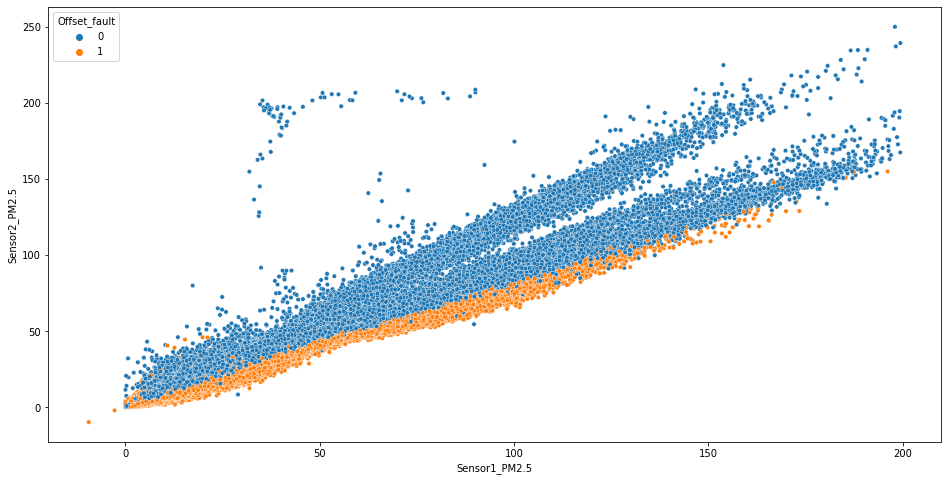

In [8]:
plt.figure(figsize=(16, 8))
train_copy= train .loc[train['Sensor1_PM2.5']<200]
sns.scatterplot(x=train_copy['Sensor1_PM2.5'], y= train_copy['Sensor2_PM2.5'], cmap="vlag", s=20, hue= train['Offset_fault'])

In [9]:
lr= LinearRegression() # Linear Model
train_copy= train.loc[train['Offset_fault']==1] # A copy of the train data
lr.fit(train_copy['Sensor1_PM2.5'].values.reshape(-1, 1), train_copy['Sensor2_PM2.5'].values.reshape(-1, 1)) # fitting the linear model
w, b= lr.coef_, lr.intercept_ # Obtaining the paramaters of the model

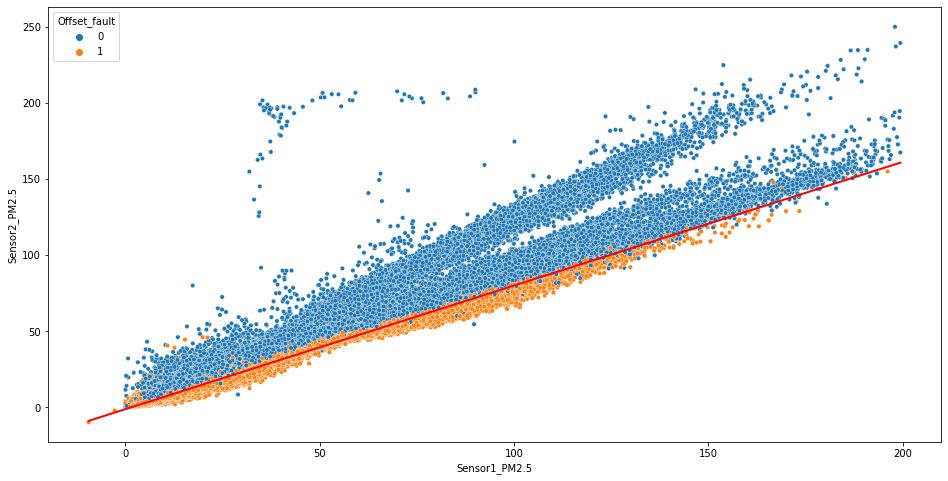

In [10]:
# Plotting the linear model
plt.figure(figsize=(16, 8))
train_copy= train .loc[train['Sensor1_PM2.5']<200] # A small copy of the train data to have a better plot
sns.scatterplot(x=train_copy['Sensor1_PM2.5'], y= train_copy['Sensor2_PM2.5'], cmap="vlag", s=20, hue= train['Offset_fault'])
x_min, x_max = np.min(train_copy['Sensor1_PM2.5'].values), np.max(train_copy['Sensor1_PM2.5'].values) # limiting the x coordinantes
pred= lr.predict(np.array([x_min, x_max]).reshape(-1,1)) # obtaining the y coordinantes
y_min, y_max= pred[0][0], pred[1][0] # obtaining the y coordinantes
plt.plot([x_min, x_max], [y_min, y_max], "r", lw=2, label="Exact Method") # plotting the line

In [11]:
train= train.loc[(train['Sensor1_PM2.5']>0) & (train['Sensor2_PM2.5']>0)] # Removing the negative sensor values

In [12]:
def inv(arr):
    res= arr.copy()
    # Under the assumption that the Faulty sensors are less frequent than the functional ones in the data, thus I used this to identify the correct class
    if arr.sum() > arr.shape[0]//2:
        res= -arr + 1
    return res

def process(data):
  data['Sensor1_PM2.5']= np.log(data['Sensor1_PM2.5']+1) # Normalizing the Sensor 1 values
  data['Sensor2_PM2.5']= np.log(data['Sensor2_PM2.5']+1) # Normalizing the Sensor 2 values

  # Generating multiple feartures from interaction between Sensor 1 and Sensor 2
  data["Sensor_avg"]= (data['Sensor1_PM2.5'] + data['Sensor2_PM2.5'])*0.5
  data["Sensor_diff"]= data['Sensor1_PM2.5'] - data['Sensor2_PM2.5']
  data["Sensor_ratio"]= data['Sensor1_PM2.5'] / data['Sensor2_PM2.5']
  data["Sensor_lr"]=  data['Sensor2_PM2.5'] -data['Sensor1_PM2.5'].transform(lambda x: x*w[0,0])
  data["Sensor_diff1"]=(data['Sensor1_PM2.5'] - data['Sensor2_PM2.5'])/(data['Sensor1_PM2.5'] + data['Sensor2_PM2.5'])
  data["Sensor_diff2"]=(data['Sensor1_PM2.5']**2 + data['Sensor2_PM2.5']**2)/(data['Sensor1_PM2.5'] + data['Sensor2_PM2.5'])**2
  data["Sensor_diff3"]=(data['Sensor1_PM2.5']**2 + data['Sensor2_PM2.5']**2)**0.5
  data["Sensor_diff4"]=(data['Sensor1_PM2.5']**2 - data['Sensor2_PM2.5']**2)/(data['Sensor1_PM2.5'] + data['Sensor2_PM2.5'])**2
  data["Sensor_diff_abs"]= abs(data['Sensor1_PM2.5'] - data['Sensor2_PM2.5'])

  # Generating Date and Time features
  data['Datetime_day']= data.Datetime.dt.day
  data['Datetime_month']= data.Datetime.dt.month
  data['Datetime_year']= data.Datetime.dt.year
  data['Datetime_hour']= data.Datetime.dt.hour

  # Grouping and averaging the two sensors values per hour 
  group = data.groupby(["Datetime_year", "Datetime_month", "Datetime_day", "Datetime_hour"]).agg({'Sensor_avg': ['mean']})
  group.columns = [ 'avg_hour' ]
  group.reset_index(inplace=True)

  data= pd.merge(data, group, on=["Datetime_year", "Datetime_month", "Datetime_day", "Datetime_hour"], how='left') # merging the group Dataframe that contains the avg_hour feature with the data

  data["Sensor1_off_avg_h"]= abs(data['Sensor1_PM2.5'] - data['avg_hour']) # difference between the Sensor 1 values and the average per hour
  data["Sensor2_off_avg_h"]= abs(data['Sensor2_PM2.5'] - data['avg_hour']) # difference between the Sensor 2 values and the average per hour
  data["Sensor_off_avg_h"]= abs(data['Sensor_avg'] - data['avg_hour']) # difference between the Sensor 1&2 avg values and the average per hour

  # Applying the same transformation of Grouping and averaging the two sensors values per day 
  group_day = data.groupby(["Datetime_year", "Datetime_month", "Datetime_day"]).agg({'Sensor_avg': ['mean']}) 
  group_day.columns = ['avg_day']
  group_day.reset_index(inplace=True)

  data= pd.merge(data, group_day, on=["Datetime_year", "Datetime_month", "Datetime_day"], how='left') # merging the group_day Dataframe that contains the avg_day feature with the data

  data["Sensor1_off_avg_d"]= abs(data['Sensor1_PM2.5'] - data['avg_day']) # difference between the Sensor 1 values and the average per day
  data["Sensor2_off_avg_d"]= abs(data['Sensor2_PM2.5'] - data['avg_day']) # difference between the Sensor 2 values and the average per day
  data["Sensor_off_avg_d"]= abs(data['Sensor_avg'] - data['avg_day']) # difference between the Sensor 1 & 2 avg values and the average per day

  # Using an unsupervised model to divise the data parts into two clusters and then using it as a feature
  data["Kmeans"]= 0 # initializing the feature

  # Selecting the features that the  model will use
  cols= ['Sensor1_PM2.5', 'Sensor2_PM2.5', 'Sensor_avg', 'Sensor_diff',
        'Sensor_ratio', 'Sensor_lr', 'Sensor_diff1', 'Sensor_diff2', 'Sensor_diff3', 'Sensor_diff4',
        'Sensor_diff_abs', 'avg_hour', 'Sensor1_off_avg_h', 'Sensor2_off_avg_h',
        'Sensor_off_avg_h', 'Sensor1_off_avg_d', 'Sensor2_off_avg_d', 'Sensor_off_avg_d']

  for i in range(group.shape[0]): # iterating through the groups of unique compositions of [Year, Month, Day, Hour]
      parc= data.loc[(data.Datetime_year== group.iloc[i][0]) & (data.Datetime_month== group.iloc[i][1]) & # Selecting the relative data points
                      (data.Datetime_day== group.iloc[i][2]) & (data.Datetime_hour== group.iloc[i][3])]
      parc_copy= parc[cols] # Selecting the columns

      # if the group contains less than 4 instances, I set it all to zeros
      if parc.shape[0]<4:
        y_km= np.zeros(parc.shape[0])
      else:
        km = KMeans(                    # Defining the unsupervised model
            n_clusters=2, init='random',
            n_init=10, max_iter=1000, 
            tol=1e-04, random_state=0)

        y_km = km.fit_predict(parc_copy) # fitting the unsupervised model
        y_km= inv(y_km) # Inversing the resulting classes if I have an inversed distribution (Check the function written above)

      data.loc[parc.index, "Kmeans"]= y_km # adding the feature 
      if i%200==0:
          print("Done {} / {}".format(i, group.shape[0]))

  # Adding some time dependant features
  data= data.sort_values(by=['Datetime']) # sorting the data by the Datetime
  # Applying the shifting process
  data["shifted_Sensor_diff_abs"]= data["Sensor_diff_abs"].shift(periods=1, fill_value=0)
  data["shifted_Sensor2_off_avg_h"]= data["Sensor2_off_avg_h"].shift(periods=1, fill_value=0)
  data["shifted_Sensor_lr"]= data["Sensor_lr"].shift(periods=1, fill_value=0) 
  data["shifted_Sensor2_PM2.5"]= data["Sensor2_PM2.5"].shift(periods=1, fill_value=0) 

  data= data.sort_index() # Resorting the data using the index

  return data

In [13]:
# Processing the train data
train= process(train)

Done 0 / 2296
Done 200 / 2296
Done 400 / 2296
Done 600 / 2296
Done 800 / 2296
Done 1000 / 2296
Done 1200 / 2296
Done 1400 / 2296
Done 1600 / 2296
Done 1800 / 2296
Done 2000 / 2296
Done 2200 / 2296


In [14]:
# Processing the test data
test= process(test)

Done 0 / 1158
Done 200 / 1158
Done 400 / 1158
Done 600 / 1158
Done 800 / 1158
Done 1000 / 1158


In [15]:
y= train["Offset_fault"] # Saving the target
df_train= train.drop(columns=['ID', 'Datetime', 'Offset_fault'], inplace=False) # Dropping ID, Datetime and Offset_fault from the train dataset
df_test= test.drop(columns=['ID', 'Datetime'], inplace=False) # Dropping ID and Datetime from the test dataset

In [16]:
df= pd.concat([df_train, df_test]) # Concatinating the train and test data
df= pd.get_dummies(df, columns=['Kmeans']) # Applying One Hot Encoding on the Kmeans feature
df.drop(columns=['Datetime_day', 'Datetime_month', 'Datetime_year', 'Datetime_hour', "Sensor_avg"], inplace=True) # Dropping time and date features
df_train= df.iloc[:len(df_train)] # Reobtaining the train data 
df_test= df.iloc[len(df_train):] # Reobtaining the test data 

# Model Training and Predictions

In [17]:
cat_preds=[] # I will use this list to store the prediction of the models across the k folds
cat_vals= np.zeros((y.shape[0], 2)) # I will use this variable to calculate the Global accuracy
skf = KFold(n_splits=3,shuffle=True, random_state=50) # Defining the kfold with 3 folds
for fold, (train_index, test_index) in enumerate(skf.split(df_train,y)): # iterating through the folds
      X_train, X_test = df_train.iloc[train_index,:], df_train.iloc[test_index,:] # Getting the train and validation dataset
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]

      # Defining the model 
      cat= CatBoostClassifier(learning_rate=0.05, depth=10, iterations=3000, eval_metric='Accuracy',
                         od_wait=20, random_state= 42, verbose=True)
      # Fitting the model
      cat.fit(X_train,y_train, eval_set=(X_test,y_test), verbose=300, early_stopping_rounds =100)

      y_pred_val = cat.predict_proba(X_test) # Predicting on the validation data
      y_pred_test = cat.predict_proba(df_test) # Predicting on the test data
      cat_preds.append(y_pred_test) # Saving the test predictions
      cat_vals[test_index]= y_pred_val

      print('Best Acc: ',accuracy_score(y_test, y_pred_val.argmax(axis=1)))
      print(50*'-')
print('Global Acc: ',accuracy_score(y, cat_vals.argmax(axis=1)))

0:	learn: 0.9607988	test: 0.9605561	best: 0.9605561 (0)	total: 249ms	remaining: 12m 26s
300:	learn: 0.9938604	test: 0.9888175	best: 0.9888175 (300)	total: 57.3s	remaining: 8m 33s
600:	learn: 0.9974087	test: 0.9899244	best: 0.9899658 (597)	total: 1m 55s	remaining: 7m 39s
900:	learn: 0.9988259	test: 0.9902968	best: 0.9903175 (892)	total: 2m 51s	remaining: 6m 38s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9904209209
bestIteration = 929

Shrink model to first 930 iterations.
Best Acc:  0.9904209208743238
--------------------------------------------------
0:	learn: 0.9586473	test: 0.9562006	best: 0.9562006 (0)	total: 190ms	remaining: 9m 30s
300:	learn: 0.9938191	test: 0.9885277	best: 0.9885277 (300)	total: 57.4s	remaining: 8m 34s
600:	learn: 0.9974035	test: 0.9898312	best: 0.9899036 (581)	total: 1m 53s	remaining: 7m 34s
900:	learn: 0.9989448	test: 0.9902760	best: 0.9902967 (894)	total: 2m 49s	remaining: 6m 35s
1200:	learn: 0.9995500	test: 0.9903898	best: 0.9904105 

In [19]:
pred_1_model= cat_preds[0].argmax(axis=1) # I took the predictions of the first fold model

# Generating the submission file dataframe
out_1_model= pd.DataFrame({'ID': test.ID, 'Offset_fault': pred_1_model})
# Exporting the submission file
out_1_model.to_csv('Verif_Best_iter3000_re_manyf_2_more_Kmeans_dum_days_depth7_diff2_lr0.05_yatoura.csv', index=False)

 * **Important Note**: I worked on my local environment using jupyter to train the model thus, when I rerunned the notebook on Google Colab, I obtained slightly better results <br>
Score using my local environment: **0.8958366048994975** <br>
Score using colab: **0.8966708542713567**
